In [2]:
# Make sure you have deepracer-utils >= 0.9

# import sys

# !{sys.executable} -m pip install --upgrade deepracer-utils
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint
import boto3, json

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs.metrics import TrainingMetrics
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [473]:
# model_logs_root = 'logs/sample-console-logs'
# # log = DeepRacerLog(model_logs_root)

from deepracer.logs import (AnalysisUtils, DeepRacerLog, S3FileHandler)
bucket = "dp123testlocal"

prefixes = ["rl-dp-rf44chun","rl-dp-rf43chun"]

prefix = prefixes[0] # i-0c7af997757c8b4e4*
prefix = prefixes[1] # i-05d052c1428a1897c*


# prefix = "rl-dp-rf36chun"
# prefix = "rl-dp-rf23chunx1-ex"

# https://us-east-2.console.aws.amazon.com/systems-manager/session-manager/i-05d052c1428a1897c?region=us-east-2#

fh = S3FileHandler(bucket=bucket,prefix=prefix)
log = DeepRacerLog(filehandler=fh)
# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    hyper_params = log.hyperparameters()
    max_episodes = hyper_params["term_cond_max_episodes"]
    pprint(hyper_params)
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()
# simulation_agg = au.simulation_agg(df,secondgroup='unique_episode')
simulation_agg = au.simulation_agg(df)

current_episode = np.max(simulation_agg["episode"])
current_iteration = np.max(simulation_agg['iteration'])

print('Number of episodes = ', current_episode)
print('Number of iterations = ', current_iteration)
# au.analyze_training_progress(simulation_agg, title='Training progress', groupby_field='unique_episode')
# au.analyze_training_progress(simulation_agg, title='Training progress')

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '5.0'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.9,
 'e_greedy_value': 1.0,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'mean squared error',
 'lr': 0.0003,
 'num_episodes_between_training': 18,
 'num_epochs': 4,
 'stack_size': 1,
 'term_cond_avg_score': 100000.0,
 'term_cond_max_episodes': 20000}
-------------
[{'speed': 1.0, 'steering_angle': 30},
 {'speed': 1.0, 'steering_angle': -30},
 {'speed': 1.4, 'steering_angle': 30},
 {'speed': 1.4, 'steering_angle': -30},
 {'speed': 1.8, 'steering_angle': 30},
 {'speed': 1.8, 'steering_angle': -30},
 {'speed': 1.6, 'steering_angle': 20},
 {'speed': 1.6, 'steering_angle': -20},
 {'speed': 2.0, 'steering_angle': 20},
 {'speed': 2.0, 'steering_angle': -20},
 {'speed': 2.4, 'steering_angle': 20},
 {'speed': 2.4, 'steering_angle': -20},
 {'speed': 2.2, 'steering_angle': 10

In [474]:
# View ten best rewarded episodes in the training
result = simulation_agg.nlargest(5, 'progress')
max_result = simulation_agg.nlargest(1, 'iteration')
# result = simulation_agg[simulation_agg["iteration"] == current_iteration].nlargest(5, 'progress')#.nsmallest(5,"time")
top_episodes = list(result["episode"])[:3]
result

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
493,27,493,380.0,150,88.160109,25.331,57.430310,864.204751,2.388421,864.204751,28.732950,980.267335,5th,0
474,26,474,350.0,162,81.531804,23.247,54.223350,807.135241,2.479429,807.135241,28.512800,989.963676,5th,0
436,24,436,311.0,184,71.993423,20.658,48.357453,697.234176,2.448875,697.234176,28.694288,968.469267,5th,0
455,25,455,281.0,173,63.828773,18.678,42.997881,615.204963,2.427046,615.204963,29.262665,963.836423,5th,0
459,25,459,244.0,219,57.823971,16.270,38.676161,573.046247,2.540984,573.046247,28.137120,991.018490,5th,0


Successfully loaded training round 1 for worker 0: Iterations: 29, Training episodes: 518, Evaluation episodes: 181


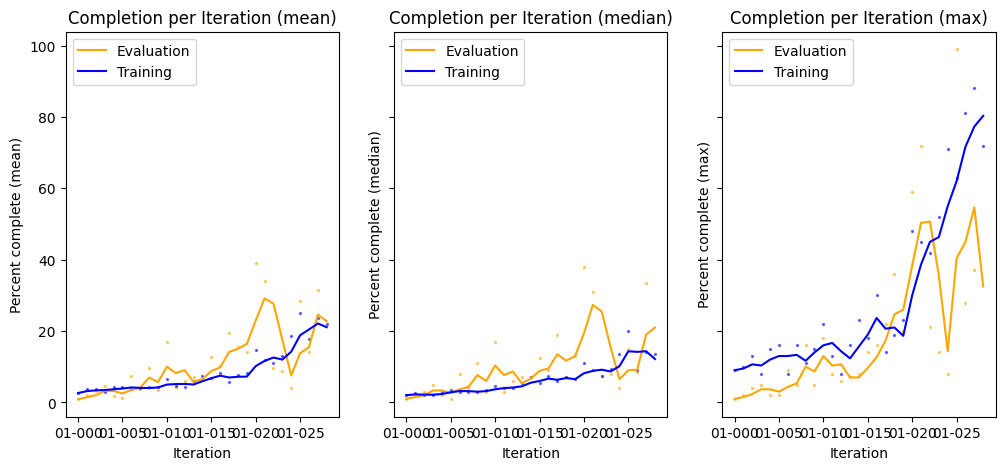

In [475]:
# metrics = contents["metrics"]
# evaluation = [v['episode'] // 18 for v in metrics if v["phase"] == "evaluation"]
# print("Completed Evaluations :",len(Counter(evaluation)))
# print(Counter(evaluation))
tm = TrainingMetrics(bucket, prefix)
rounds = np.array([[1,1]])
NUM_ROUNDS = len(rounds)
_ = tm.plotProgress(method=['mean','median','max'],rolling_average=3,rounds=rounds[:,0])

In [404]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    pass
    # au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

No complete laps yet.


In [378]:
# au.scatter_aggregates(complete_ones, 'Stats for all laps')
# complete_ones_last20 = complete_ones[complete_ones['iteration'] >= current_iteration - 10]
# complete_ones_last20
# au.scatter_aggregates(complete_ones_last20, 'Stats for all laps')

In [379]:
complete_ones.groupby("iteration")['complete'].count()[-7::].sort_index(ascending=False)

iteration
109    1
103    1
102    1
101    1
96     1
87     1
86     1
Name: complete, dtype: int64

In [380]:
print("Model Name:", prefix)
print("Completed Ones:",len(complete_ones))
print("Completed Ones / Episodes:", 100 * len(complete_ones) / current_episode)
print("Latest Episode:",current_episode, f"({max_episodes})")
select_max = 0
result = complete_ones.nlargest(20, 'iteration')
result = result[(result["iteration"] == current_iteration)].sort_values(by='time',ascending=True)
if not len(result):
    print("** No completion for latest iteration **")
    result = simulation_agg.nlargest(10, 'iteration')
    result = result[(result["iteration"] == current_iteration)].sort_values(by='progress',ascending=False)
    print("Latest Iteration:",list(result.head()["iteration"])[0])
    print("Latest Iteration Best Progress / Time:", list(result.head()["progress"])[0], list(result.head()["time"])[0])
else:
    print("Latest Iteration:",list(result.head()["iteration"])[0])
    print("Latest Iteration Best Time:", list(result.head()["time"])[0])

if select_max:
    pass
else:
    # View five fastest complete laps
    result = complete_ones.nsmallest(10, 'time')
top_episodes = list(result["episode"])[:3]
result

Model Name: rl-dp-rf43chun-ex
Completed Ones: 14
Completed Ones / Episodes: 0.6947890818858561
Latest Episode: 2015 (20000)
** No completion for latest iteration **
Latest Iteration: 111
Latest Iteration Best Progress / Time: 52.40581864281393 12.284999999999854


,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
963,53,963,358.0,36,100.0,23.765,64.468524,400.898533,2.831285,400.898533,23.765,400.898533,3rd,1
1834,101,1834,357.0,162,100.0,23.804,63.977845,394.869938,2.862745,394.869938,23.804,394.869938,5th,1
833,46,833,359.0,150,100.0,23.873,63.569732,369.042366,2.833983,369.042366,23.873,369.042366,3rd,1
1295,71,1295,359.0,173,100.0,23.885,63.467631,375.149248,2.793872,375.149248,23.885,375.149248,4th,1
1866,103,1866,360.0,70,100.0,23.945,63.525210,405.496555,2.856667,405.496555,23.945,405.496555,5th,1
1731,96,1731,362.0,127,100.0,24.054,64.253363,421.729484,2.822099,421.729484,24.054,421.729484,5th,1
1033,57,1033,363.0,150,100.0,24.128,64.201817,373.283157,2.782920,373.283157,24.128,373.283157,3rd,1
1582,87,1582,363.0,25,100.0,24.146,63.648972,373.164760,2.811570,373.164760,24.146,373.164760,4th,1
862,47,862,364.0,25,100.0,24.203,64.537962,375.882340,2.777473,375.882340,24.203,375.882340,3rd,1
1032,57,1032,365.0,139,100.0,24.262,64.000818,371.301678,2.810411,371.301678,24.262,371.301678,3rd,1


In [314]:
# result = complete_ones.nlargest(10, 'reward')
# top_episodes = list(result["episode"])[:3]
# result
# result_ = complete_ones[(complete_ones["start_at"] == 0)]
# result_0

Loaded 231 waypoints


<AxesSubplot:>

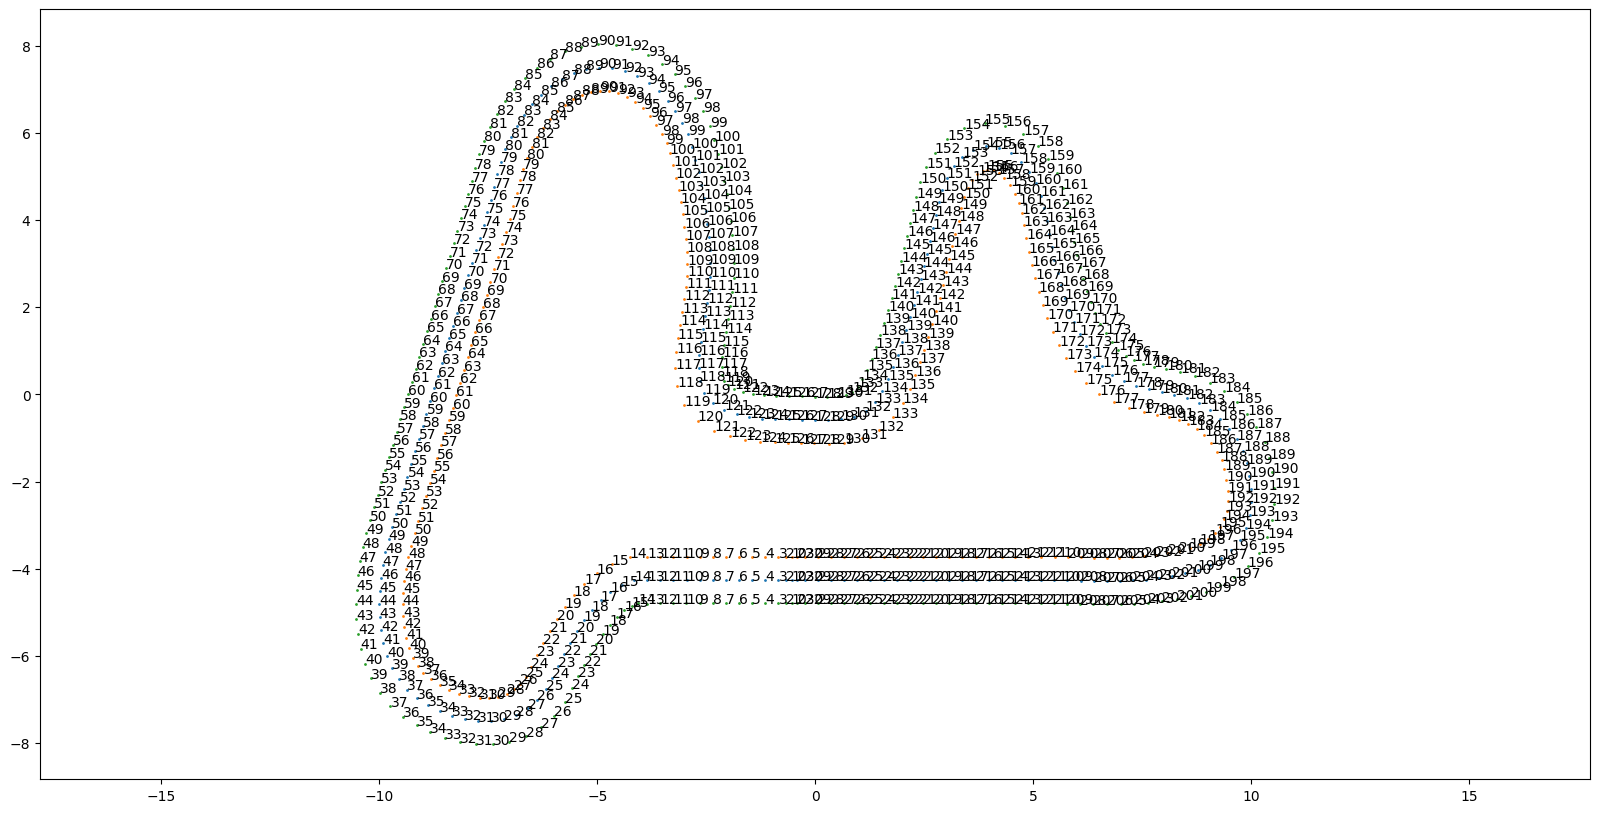

In [354]:
tu = TrackIO()

for track in tu.get_tracks():
    pass
    # print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

    # We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "reinvent_base"

track_name = "thunder_hill_open.npy"
# track_name = "arctic_pro.npy"
track_name = "jyllandsringen_pro_cw"
track_name = "penbay_open_cw"
track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

In [13]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
# complete_ones = df
# complete_ones = df[df['progress']==100]
# pu.plot_track(complete_ones, track,value_field=7)

### Path taken in a particular episode

[493, 474, 436]


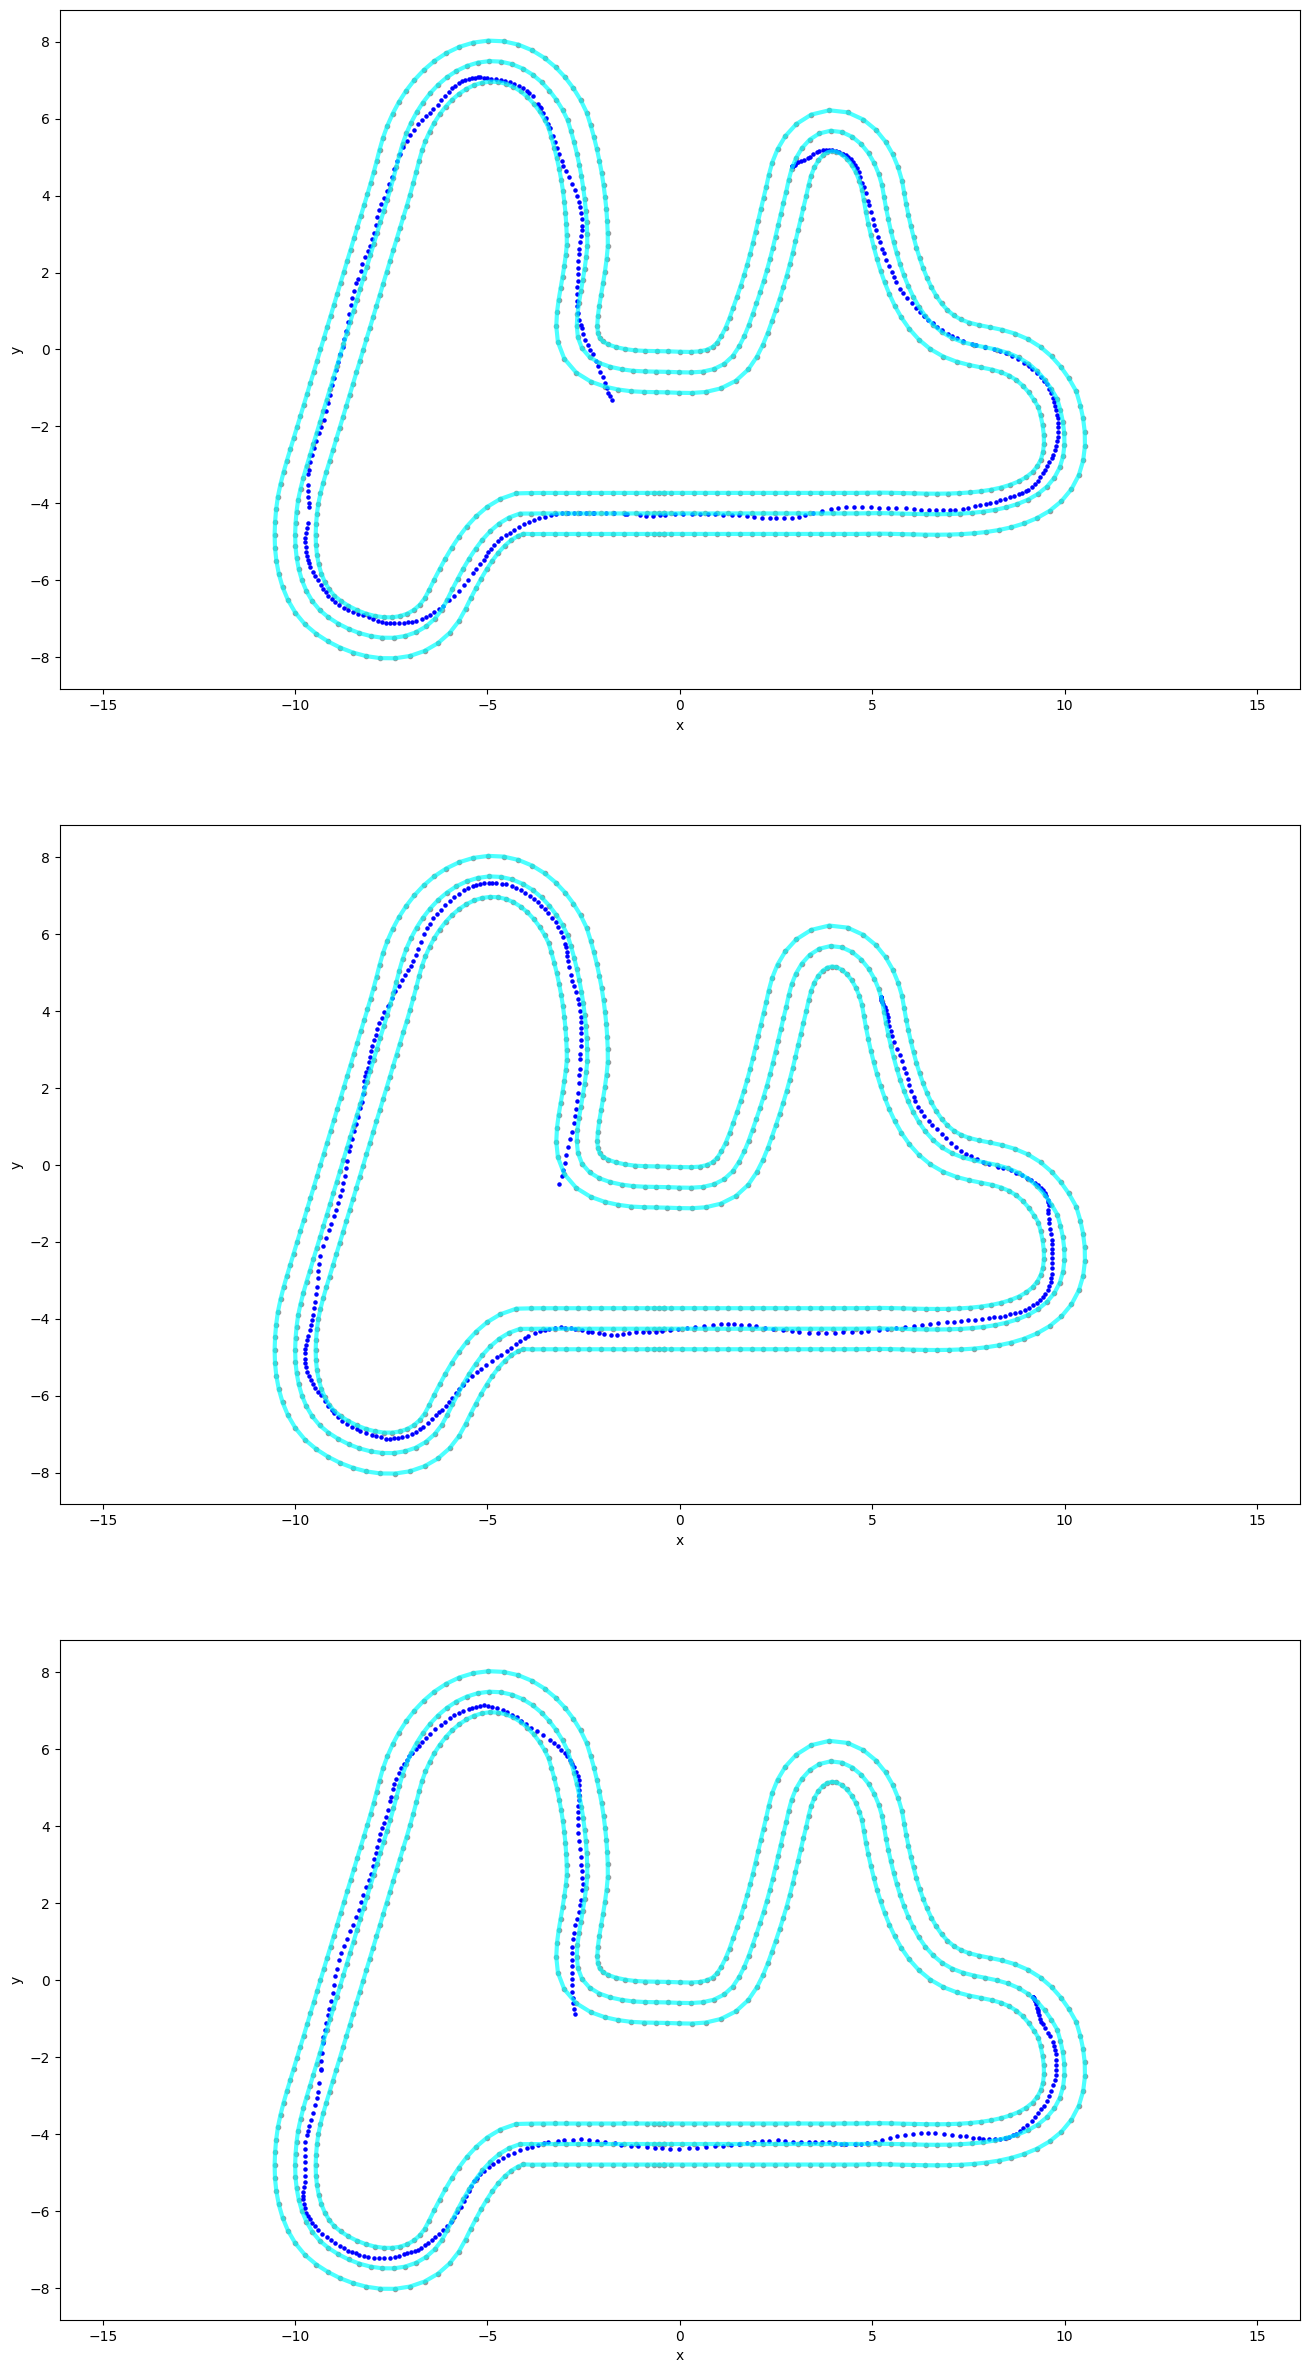

<Figure size 640x480 with 0 Axes>

In [476]:
episode_id = top_episodes
# episode_id = [3534]
print(episode_id)
# pu.plot_selected_laps(episode_id, df, track,section_to_plot="unique_episode")
pu.plot_selected_laps(episode_id, df, track,section_to_plot="episode")

27


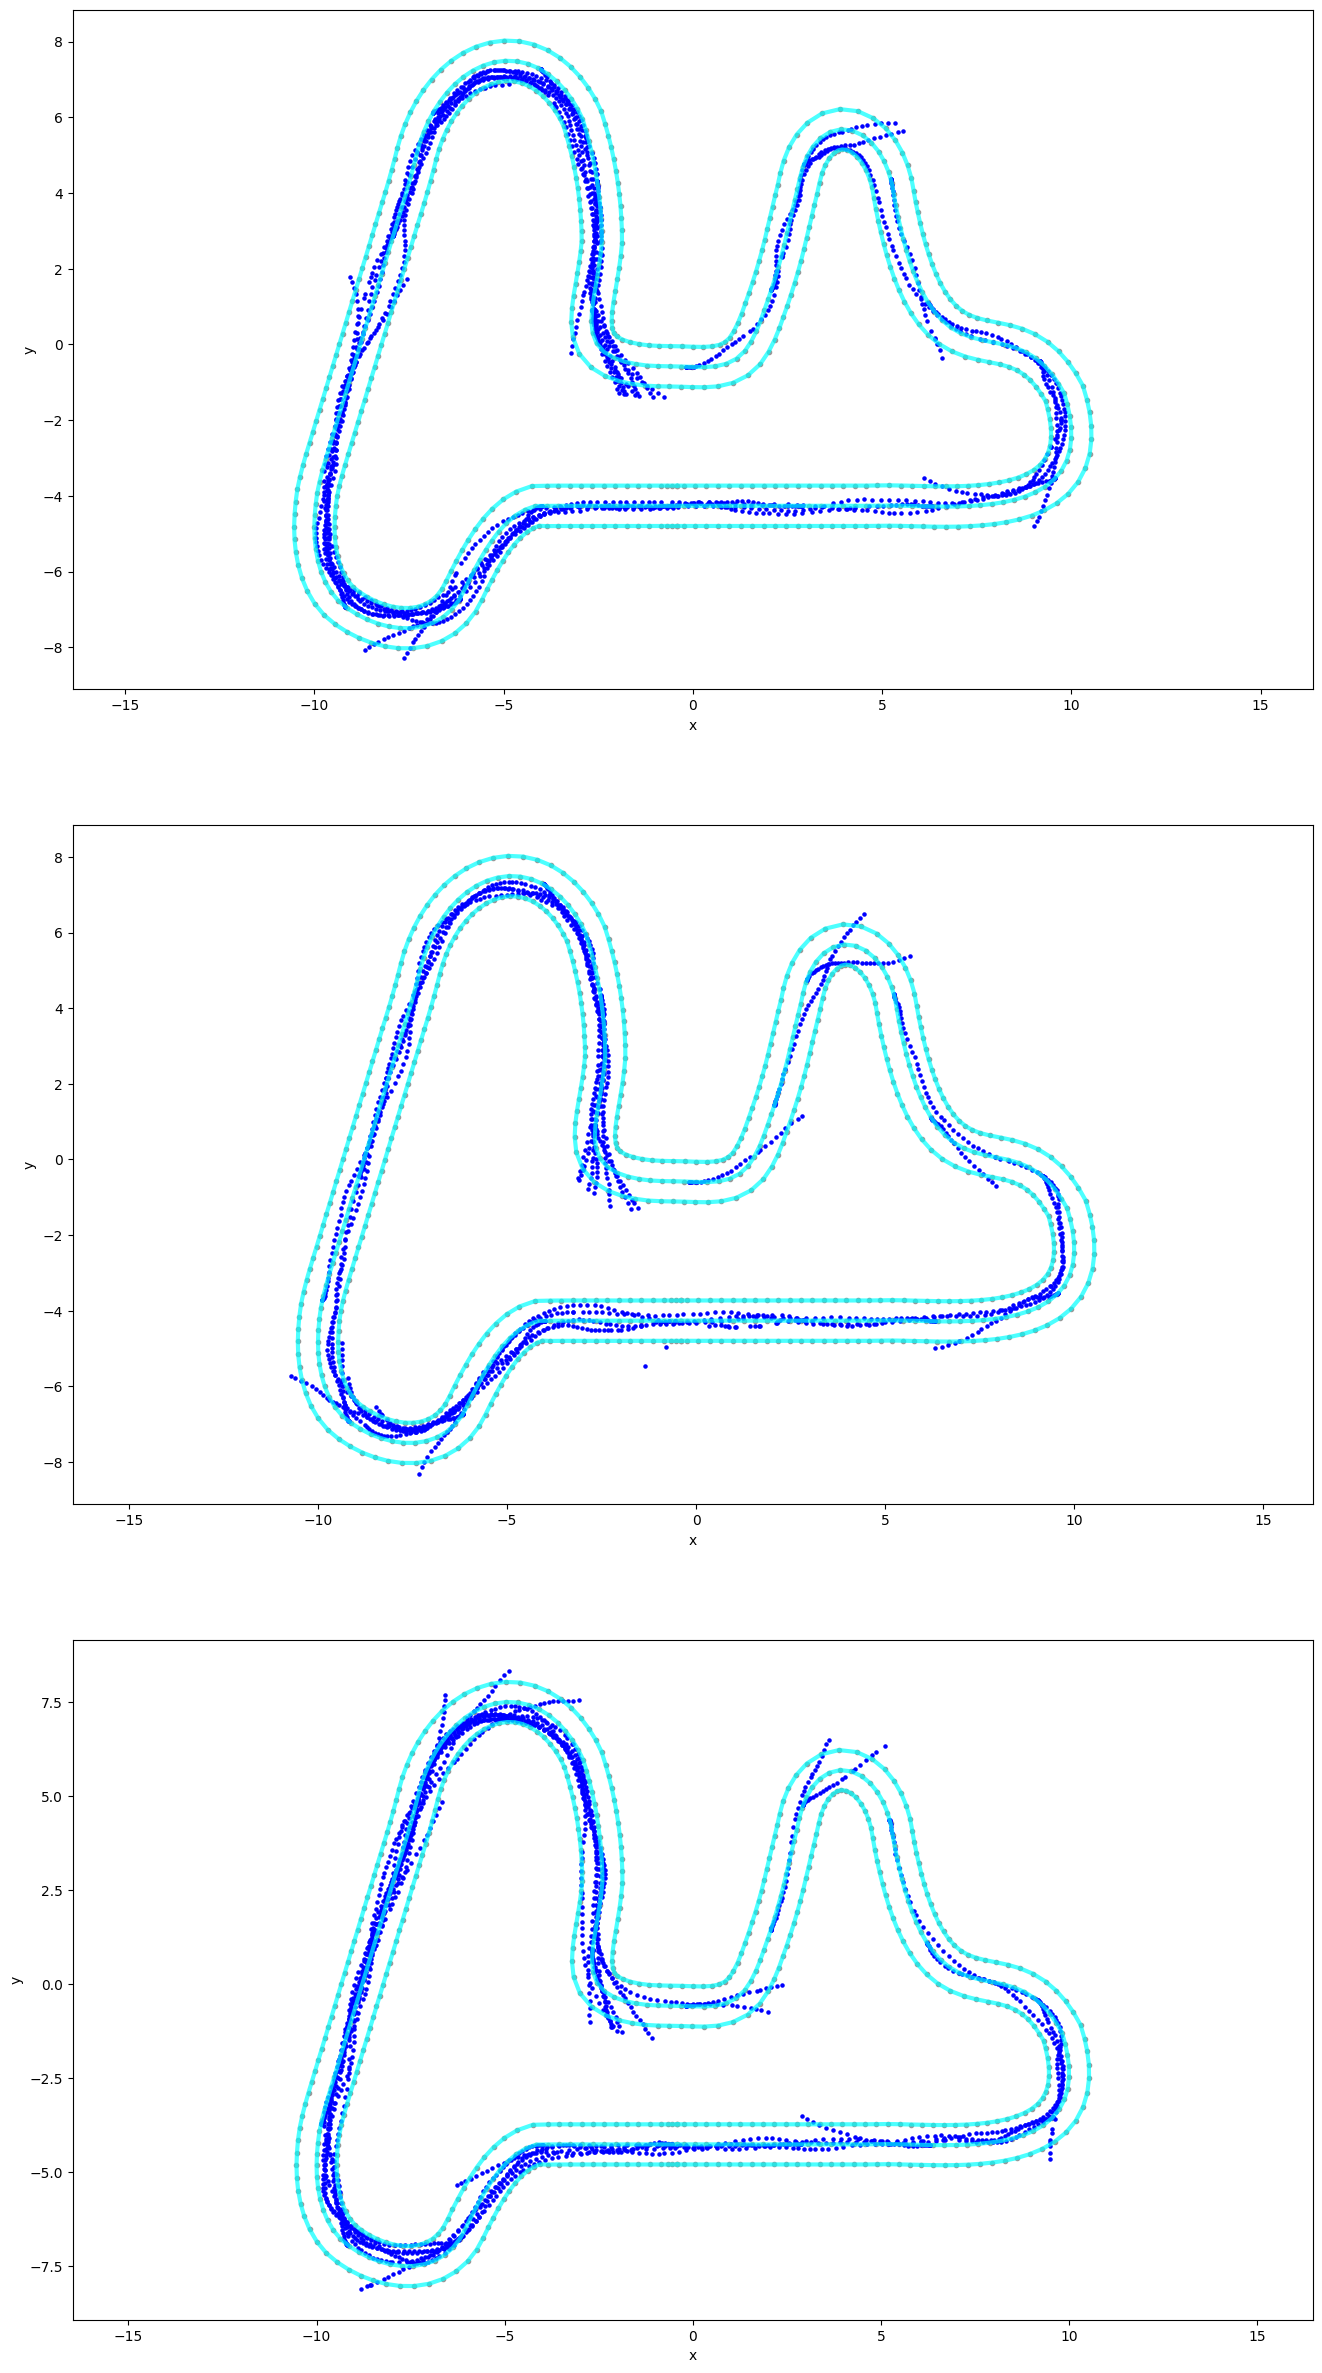

<Figure size 640x480 with 0 Axes>

In [477]:
iteration_id = current_iteration
# iteration_id = 36
print(iteration_id)
iteration_id = list(range(iteration_id-2,iteration_id+1)) 
iteration_id = iteration_id[::-1]

pu.plot_selected_laps(iteration_id, df, track, section_to_plot = 'iteration')

In [468]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)
ep = 458
# View all steps data for episode 10
df[df['episode']==ep]

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,...,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,new_reward
17297,458,1.0,6.313457,-4.279179,179.613025,-2.5,3.8,27,0.000000,False,...,0.204219,207,68.667443,1753.373,prepare,0.0,25,0,458,0.000000
17298,458,2.0,6.313693,-4.279271,179.624352,2.5,3.4,24,2.861381,False,...,0.203873,207,68.667443,1753.428,in_progress,0.0,25,0,458,2.861381
17299,458,3.0,6.304107,-4.276047,178.797949,-20.0,2.4,11,2.188423,False,...,0.217920,207,68.667443,1753.487,in_progress,0.0,25,0,458,2.188423
17300,458,4.0,6.279976,-4.258977,174.799400,2.5,3.8,26,2.830455,False,...,0.253529,207,68.667443,1753.550,in_progress,0.0,25,0,458,2.830455
17301,458,5.0,6.245577,-4.242988,171.697275,10.0,2.2,12,2.303371,False,...,0.304059,207,68.667443,1753.624,in_progress,0.0,25,0,458,2.303371
17302,458,6.0,6.189988,-4.234735,171.560503,10.0,2.2,12,2.341171,False,...,0.385227,208,68.667443,1753.689,in_progress,0.0,25,0,458,2.341171
17303,458,7.0,6.127995,-4.231197,172.818165,10.0,2.2,12,2.377577,False,...,0.475589,208,68.667443,1753.771,in_progress,0.0,25,0,458,2.377577
17304,458,8.0,6.027395,-4.227725,174.823321,10.0,2.2,12,2.427172,False,...,0.622588,208,68.667443,1753.814,in_progress,0.0,25,0,458,2.427172
17305,458,9.0,5.946189,-4.229445,176.817192,10.0,2.2,12,2.482755,False,...,0.740745,208,68.667443,1753.902,in_progress,0.0,25,0,458,2.482755
17306,458,10.0,5.820469,-4.239541,-179.688553,2.5,3.8,26,3.031808,False,...,0.923395,209,68.667443,1753.959,in_progress,0.0,25,0,458,3.031808


In [ ]:
episode_id = [ep]
closest_waypoint = 67
df_temp = df[(df["closest_waypoint"] == closest_waypoint) & (df["episode"] == episode_id[0])]
df_temp

In [ ]:
pu.plot_selected_laps(episode_id, df_temp, track,section_to_plot="episode")

In [ ]:
track_breakdown.keys()

In [ ]:
abu.action_breakdown(df, track, track_breakdown=track_breakdown.get('reinvent2018'), episode_ids=[2564])

In [192]:
import time
from IPython.display import clear_output

for i in range(10):
    model_data = []
    for prefix in prefixes:
        fh = S3FileHandler(bucket=bucket,prefix=prefix)
        log = DeepRacerLog(filehandler=fh)
        # load logs into a dataframe
        log.load()

        try:
            hyper_params = log.hyperparameters()
            max_episodes = hyper_params["term_cond_max_episodes"]
        except Exception:
            print("Robomaker logs not available")

        df = log.dataframe()
        # simulation_agg = au.simulation_agg(df,secondgroup='unique_episode')
        simulation_agg = au.simulation_agg(df)

        current_episode = np.max(simulation_agg["episode"])
        current_iteration = np.max(simulation_agg['iteration'])
        model_data.append([prefix, f"{current_episode}/{max_episodes}"])
    clear_output(wait=True)
    [print(i) for i in model_data]
    time.sleep(300)
    

['rl-dp-rf16chun-ex-ex-ex-ex-ex', '4913/5000']
['rl-dp-rf23chunx1', '8675/10000']
['rl-dp-rf23chun-ex-ex-ex', '5741/20000']
['rl-dp-rf23chunx2', '719/30000']
